In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle

from math import sin, cos, pi
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Flatten, Conv2D, LeakyReLU, GlobalAveragePooling2D, MaxPooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import ResNet50

tf.random.set_seed(18)
np.random.seed(18)

In [27]:
train_data = pd.read_csv('/content/drive/MyDrive/face/training.csv')
test_data = pd.read_csv('/content/drive/MyDrive/face/test.csv')
lookid_data = pd.read_csv('/content/drive/MyDrive/face/IdLookupTable.csv')

print(train_data.shape, test_data.shape)

(7049, 31) (1783, 2)


In [28]:
# Take a look at the sample data
pd.set_option("display.max_columns", 100)

train_data[:3].T

,0,1,2
left_eye_center_x,66.033564,64.332936,65.057053
left_eye_center_y,39.002274,34.970077,34.909642
right_eye_center_x,30.227008,29.949277,30.903789
right_eye_center_y,36.421678,33.448715,34.909642
left_eye_inner_corner_x,59.582075,58.85617,59.412
left_eye_inner_corner_y,39.647423,35.274349,36.320968
left_eye_outer_corner_x,73.130346,70.722723,70.984421
left_eye_outer_corner_y,39.969997,36.187166,36.320968
right_eye_inner_corner_x,36.356571,36.034723,37.678105
right_eye_inner_corner_y,37.389402,34.361532,36.320968


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [30]:
test_data[:3]

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...


Handle missing values

In [31]:
# Now we deal with missing values

print("How many columns contain missing values?")
print(train_data.isnull().any().value_counts())
print("------------------")
print("The number of missing values for each column:")
print(train_data.isnull().sum())

How many columns contain missing values?
True     28
False     3
dtype: int64
------------------
The number of missing values for each column:
left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_r

In [32]:
print("Size of original dataframe: "+str(len(train_data))+'x'+str(len(train_data.columns))+'\n')
train_aug = train_data.dropna()
print("Size of dataframe after dropping rows of missing values, which is used for data augmentation: "
      +str(len(train_aug))+'x'+str(len(train_aug.columns))+'\n')

Size of original dataframe: 7049x31

Size of dataframe after dropping rows of missing values, which is used for data augmentation: 2140x31



In [33]:
# One option: fill the missing values with the previous values in that row
train_fill = train_data.fillna(method = 'ffill')
print("Size of dataframe after filling blanks: "
      +str(len(train_fill))+'x'+str(len(train_fill.columns))+'\n')

Size of dataframe after filling blanks: 7049x31



In [34]:
def prep_x_y (train):
    """
    Function to extract X and y from training set:
    INPUT:
        train: dataframe with shape (n,31)
    OUTPUT:
        X: numpy array which contains image data, shape (n,96,96,1)
        y: numpy array with shape (n, 30)
    """
    imgs = []
    pnts = []
    
    n = train.shape[0]
    
    X_tr = train['Image'] # X part
    y_tr = train.drop('Image',axis = 1) # y part
    
    for i in range(n):
        img = X_tr.iloc[i]
        img = img.split(' ')
        imgs.append(img)
        
        pnt = y_tr.iloc[i,:] # take the ith row data
        pnts.append(pnt)

    X_train = np.array(imgs,dtype = 'float')
    X_train = X_train.reshape(-1,96,96,1)
    y_train = np.array(pnts,dtype = 'float')
    X_train = X_train / 255.0
    
    return X_train, y_train

Image agumentation

In [35]:
# These are used as base for image augmentation

X_aug, y_aug = prep_x_y(train_aug)

print(X_aug.shape)
print(X_aug.min(), X_aug.max())
print("")

print(y_aug.shape)
print(y_aug.min(), y_aug.max())

(2140, 96, 96, 1)
0.0 1.0

(2140, 30)
3.82624305628 95.8089831215


In [36]:
# These are to be included in the final training set

X_fill, y_fill = prep_x_y(train_fill)

print(X_fill.shape)
print(X_fill.min(), X_fill.max())

print(y_fill.shape)
print(y_fill.min(), y_fill.max())

(7049, 96, 96, 1)
0.0 1.0
(7049, 30)
0.686592 95.9356444444


In [37]:
def plot_images(images, points, ncols, shrinkage=0.2):
  """
  Function to plot images and their lables:
  INPUT:
      images: numpy array with shape (N, d, d, c) dtype=float
      points: numpy array with shape (N,), dtype=float
      ncols: number of columns in the resulting image grid
      shrinage: how much each image to be shrinked for display
  """
  
  nindex, height, width, intensity = images.shape
  nrows = nindex//ncols
  print(f"Number of rows: {nrows}, number of cols: {ncols}")
  
  fig_width = int(width*ncols*shrinkage)
  fig_height = int(height*nrows*shrinkage)

  fig, axes = plt.subplots(nrows, ncols, 
                          figsize=(fig_width, fig_height))
  print(f"Figure width: {fig_width}, height: {fig_height}")
  axes = axes.flatten()
  
  for k in range(nindex):
    img = images[k]
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    pnt_x = [points[k][2*j] for j in range(15)]
    pnt_y = [points[k][2*j+1] for j in range(15)]
    ax.scatter(pnt_x,pnt_y,s=50,c='r')
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()


Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


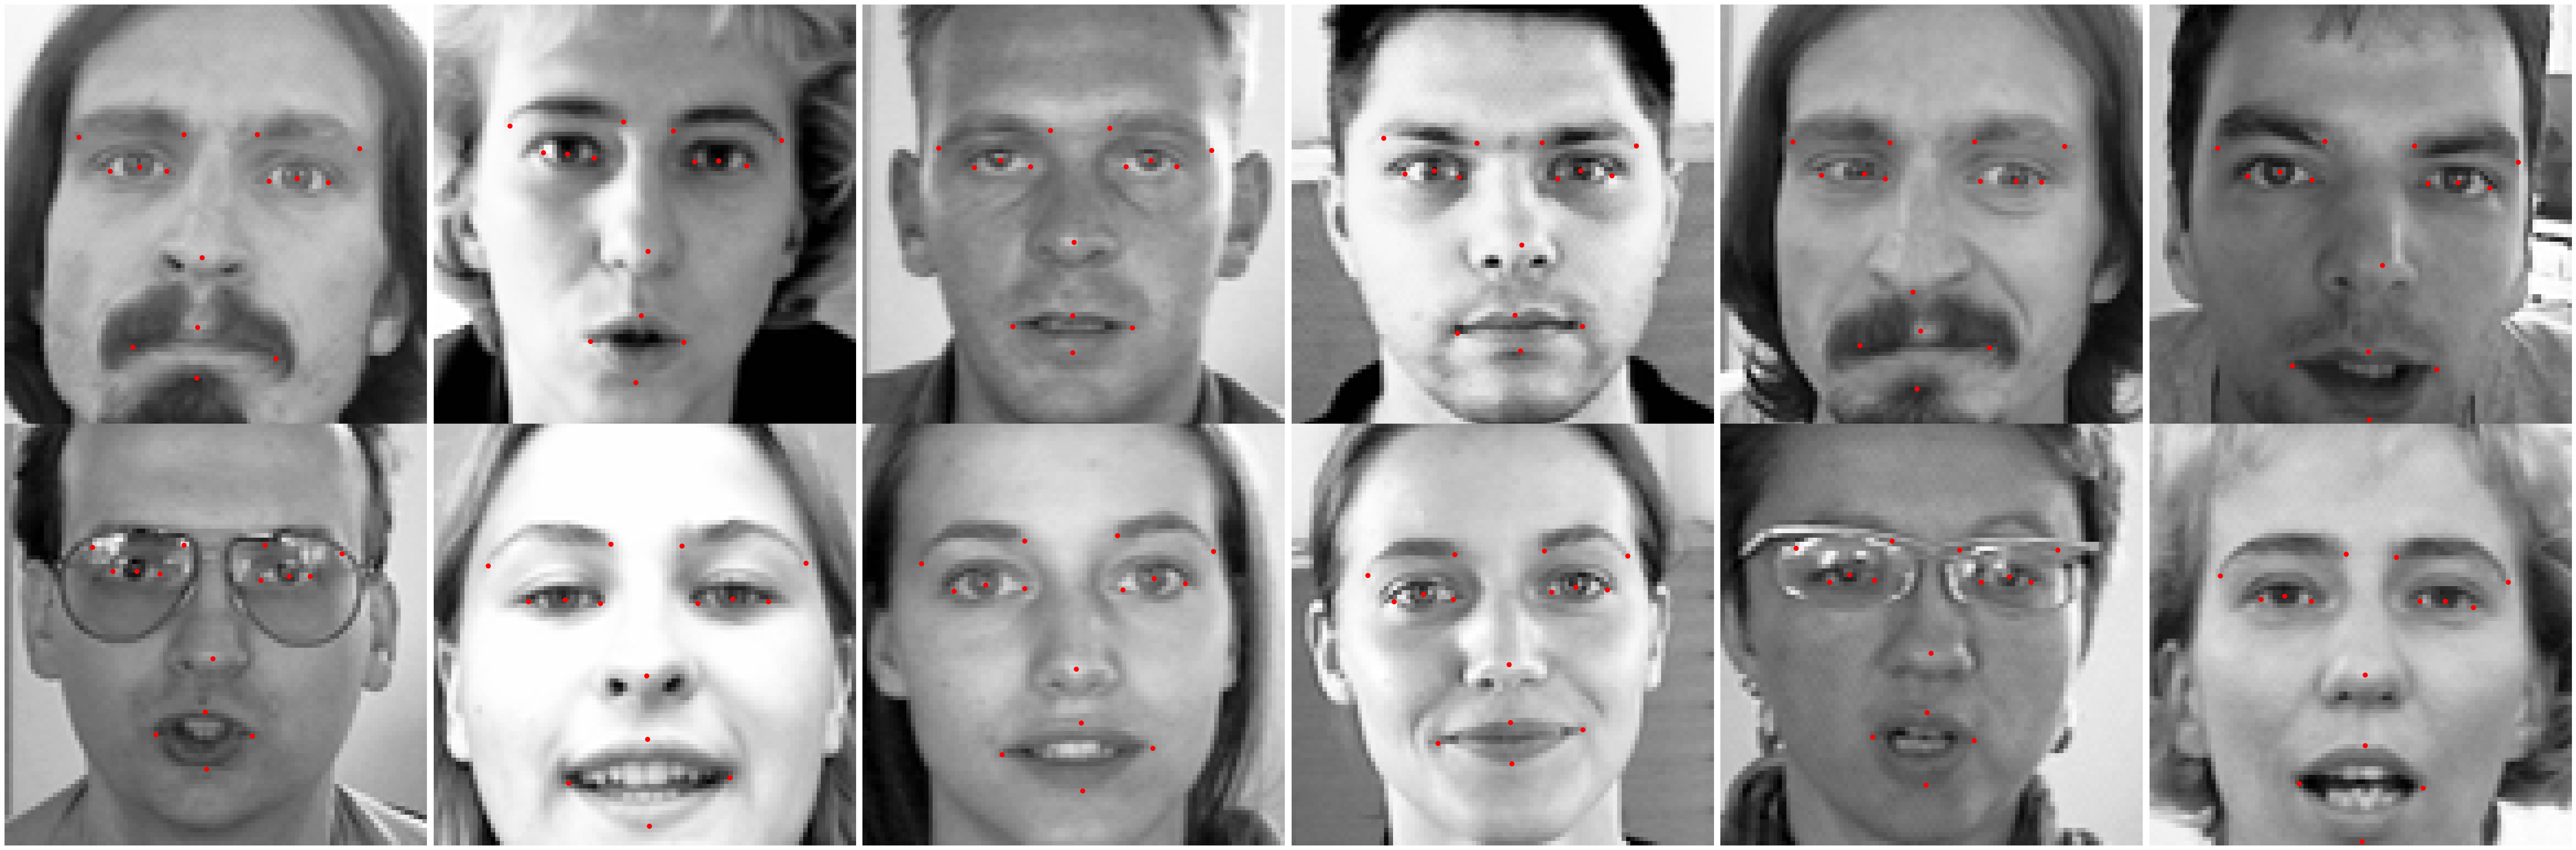

In [38]:
plot_images(X_aug[:12], y_aug[:12], 6, shrinkage=0.1)

In [39]:
X_aug.shape

(2140, 96, 96, 1)

In [40]:
y_aug.shape

(2140, 30)

In [41]:
def aug_rotation(X, y, rotation_angles=[15]):
    """
    Function to rotate images (X) and points (y) in the same time.
    INPUT:
    	X: numpy array with shape (n, d, d, c)
    	y: points to plot with shape (n, m)
        rotation_angles: a list of angles to rotate
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)

    """

    rotated_images = []
    rotated_keypoints = []
    
    size = X.shape[1] # suppose h == w
    
    center = (int(size/2), int(size/2))
    
    for angle in rotation_angles:
        for angle in [angle, -angle]:
            rot = cv2.getRotationMatrix2D(center, angle, 1.)
            angle_rad = -angle*pi/180.
            
            for image in X:
                rotated_image = cv2.warpAffine(image.reshape(size,size), rot, (size, size), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
                
            for keypoint in y:
                rotated_keypoint = keypoint - int(size/2)
                
                for idx in range(0, len(rotated_keypoint), 2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += size/2   
                rotated_keypoints.append(rotated_keypoint)
    
    return np.reshape(rotated_images,(-1,size,size,1)), np.array(rotated_keypoints)

In [42]:
def aug_shift(X, y, pixel_shifts=[15]):
    """
    Function to shift images (X) and points (y) in the same time.
    INPUT:
    	X: numpy array with shape (n, d, d, c)
    	y: points to plot with shape (n, m)
        pixel_shifts: a list of values indicating horizontal & vertical shift amount in pixels
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)
    """
    size = X.shape[1]
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            sh = np.float32([[1,0,shift_x],[0,1,shift_y]])
            
            for image, keypoint in zip(X, y):
                shifted_image = cv2.warpAffine(image, sh, (size,size), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<size):
                    shifted_images.append(shifted_image.reshape(size,size,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,size)
    return np.array(shifted_images), np.array(shifted_keypoints)

In [43]:
def aug_brightness(X, y, brightness_range=[0.6,1.2]):
    """
    Function to adjust the brightness of images (X) 
    INPUT:
    	X: numpy array with shape (n, d, d, c)
    	y: points to plot with shape (n, m)
        brightness_range: a list of two values to decrease/increase brightness
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)
    Note:
        Brightness is pre-defined as either 1.2 times or 0.6 times
    """
    altered_brightness_images = []
    inc_brightness_images = np.clip(X*brightness_range[1], 0, 255)    
    dec_brightness_images = np.clip(X*brightness_range[0], 0, 255)    
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return np.array(altered_brightness_images), np.concatenate((y, y))

In [44]:
def aug_noise(X, y, noise=0.008):
    """
    Function to add noises images (X) 
    INPUT:
    	X: numpy array with shape (n, d, d, c)
    	y: points to plot with shape (n, m)
        noise: a value times a random number of normal distribution as noise impact
    OUTPUT:
        augmented images with shape (n, d, d, c)
        augmented points with shape (n, m)
    """
    noisy_images = []
    size = X.shape[1]
    for image in X:
        noisy_image = cv2.add(image, noise*np.random.randn(size,size,1))    
        noisy_images.append(noisy_image.reshape(size,size,1))
    return np.array(noisy_images), y

Apply functions

(4280, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


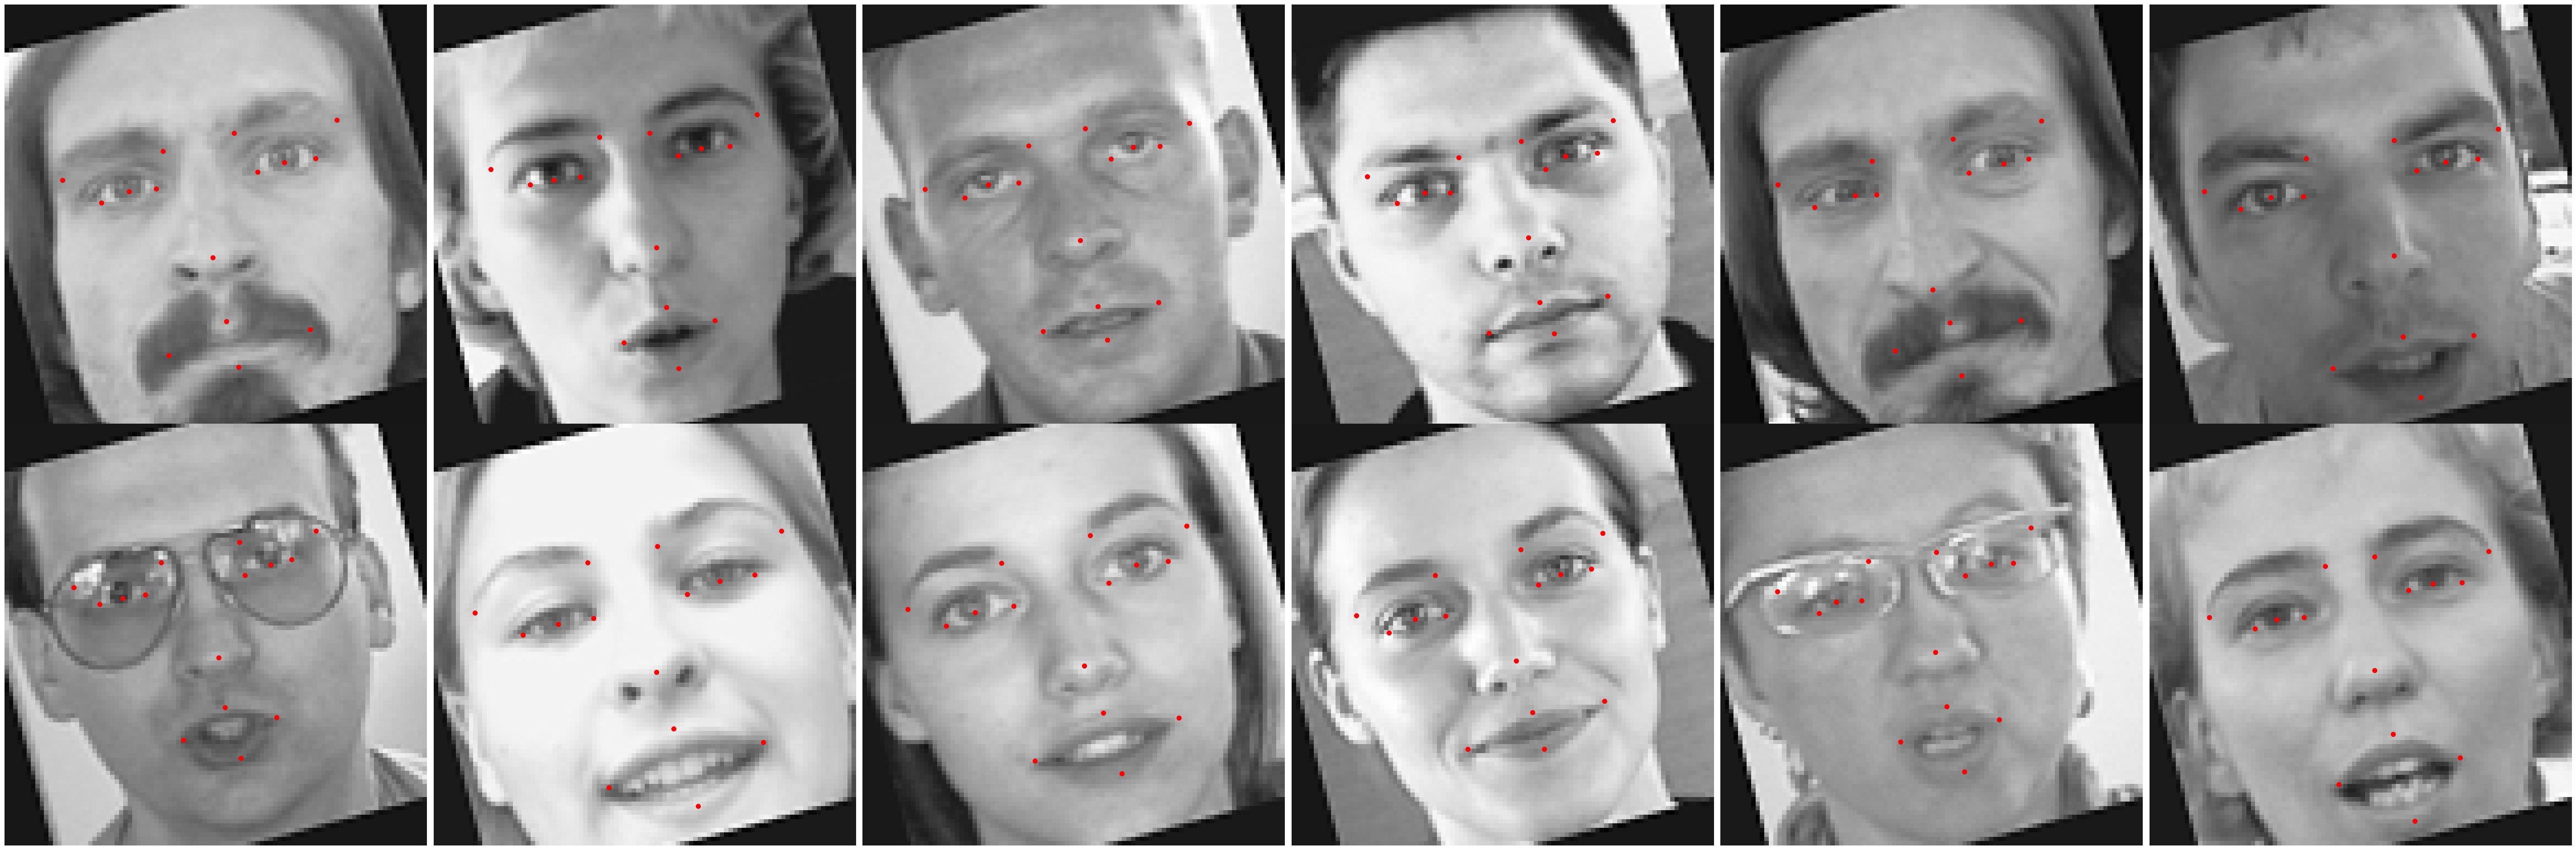

In [45]:
X_rot, y_rot = aug_rotation(X_aug,y_aug)
print(X_rot.shape)
plot_images(X_rot[:12], y_rot[:12], 6, shrinkage=0.1)

(3946, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


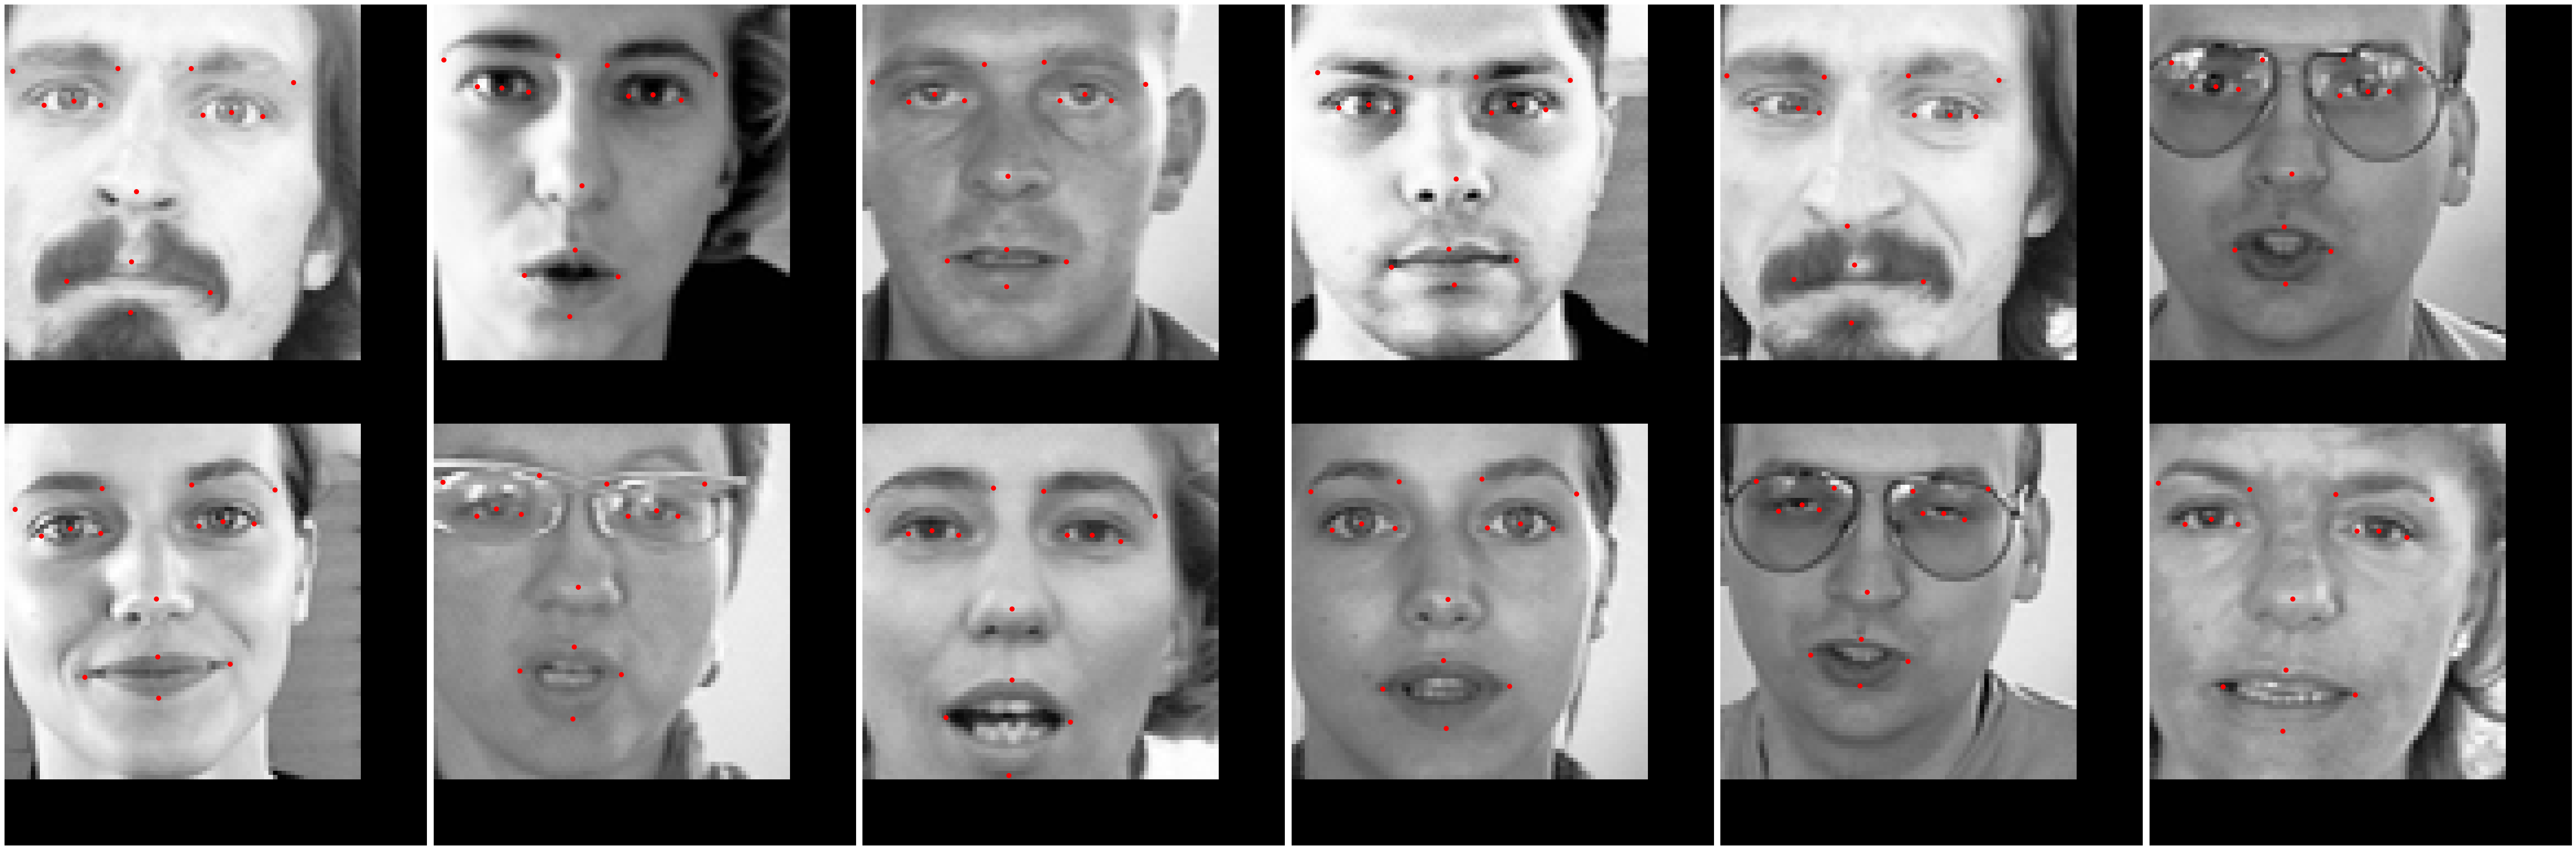

In [46]:
X_shift, y_shift = aug_shift(X_aug,y_aug)
print(X_shift.shape)
plot_images(X_shift[:12], y_shift[:12], 6, shrinkage=0.1)

(4280, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


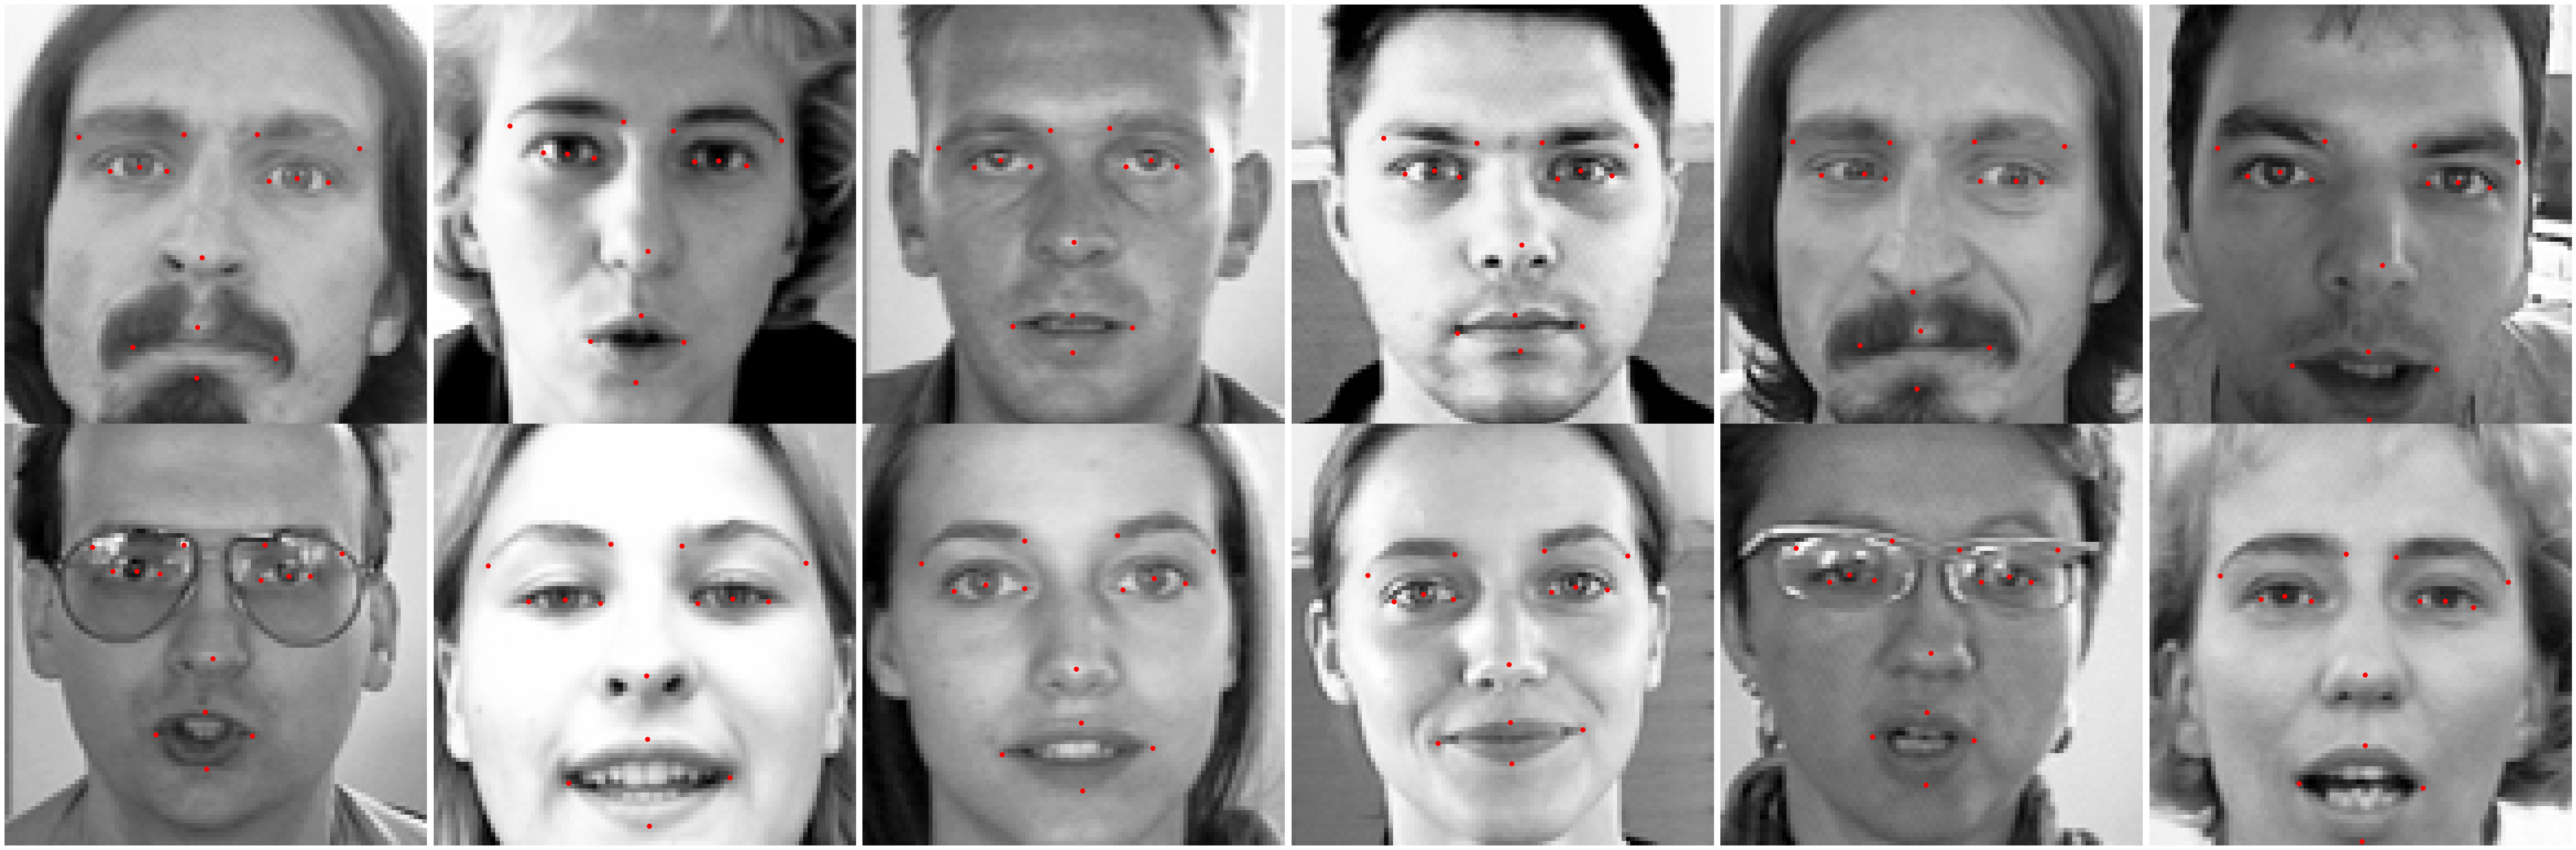

In [47]:
X_brt, y_brt = aug_brightness(X_aug,y_aug)
print(X_brt.shape)
plot_images(X_brt[:12], y_brt[:12], 6, shrinkage=0.1)

(2140, 96, 96, 1)
Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


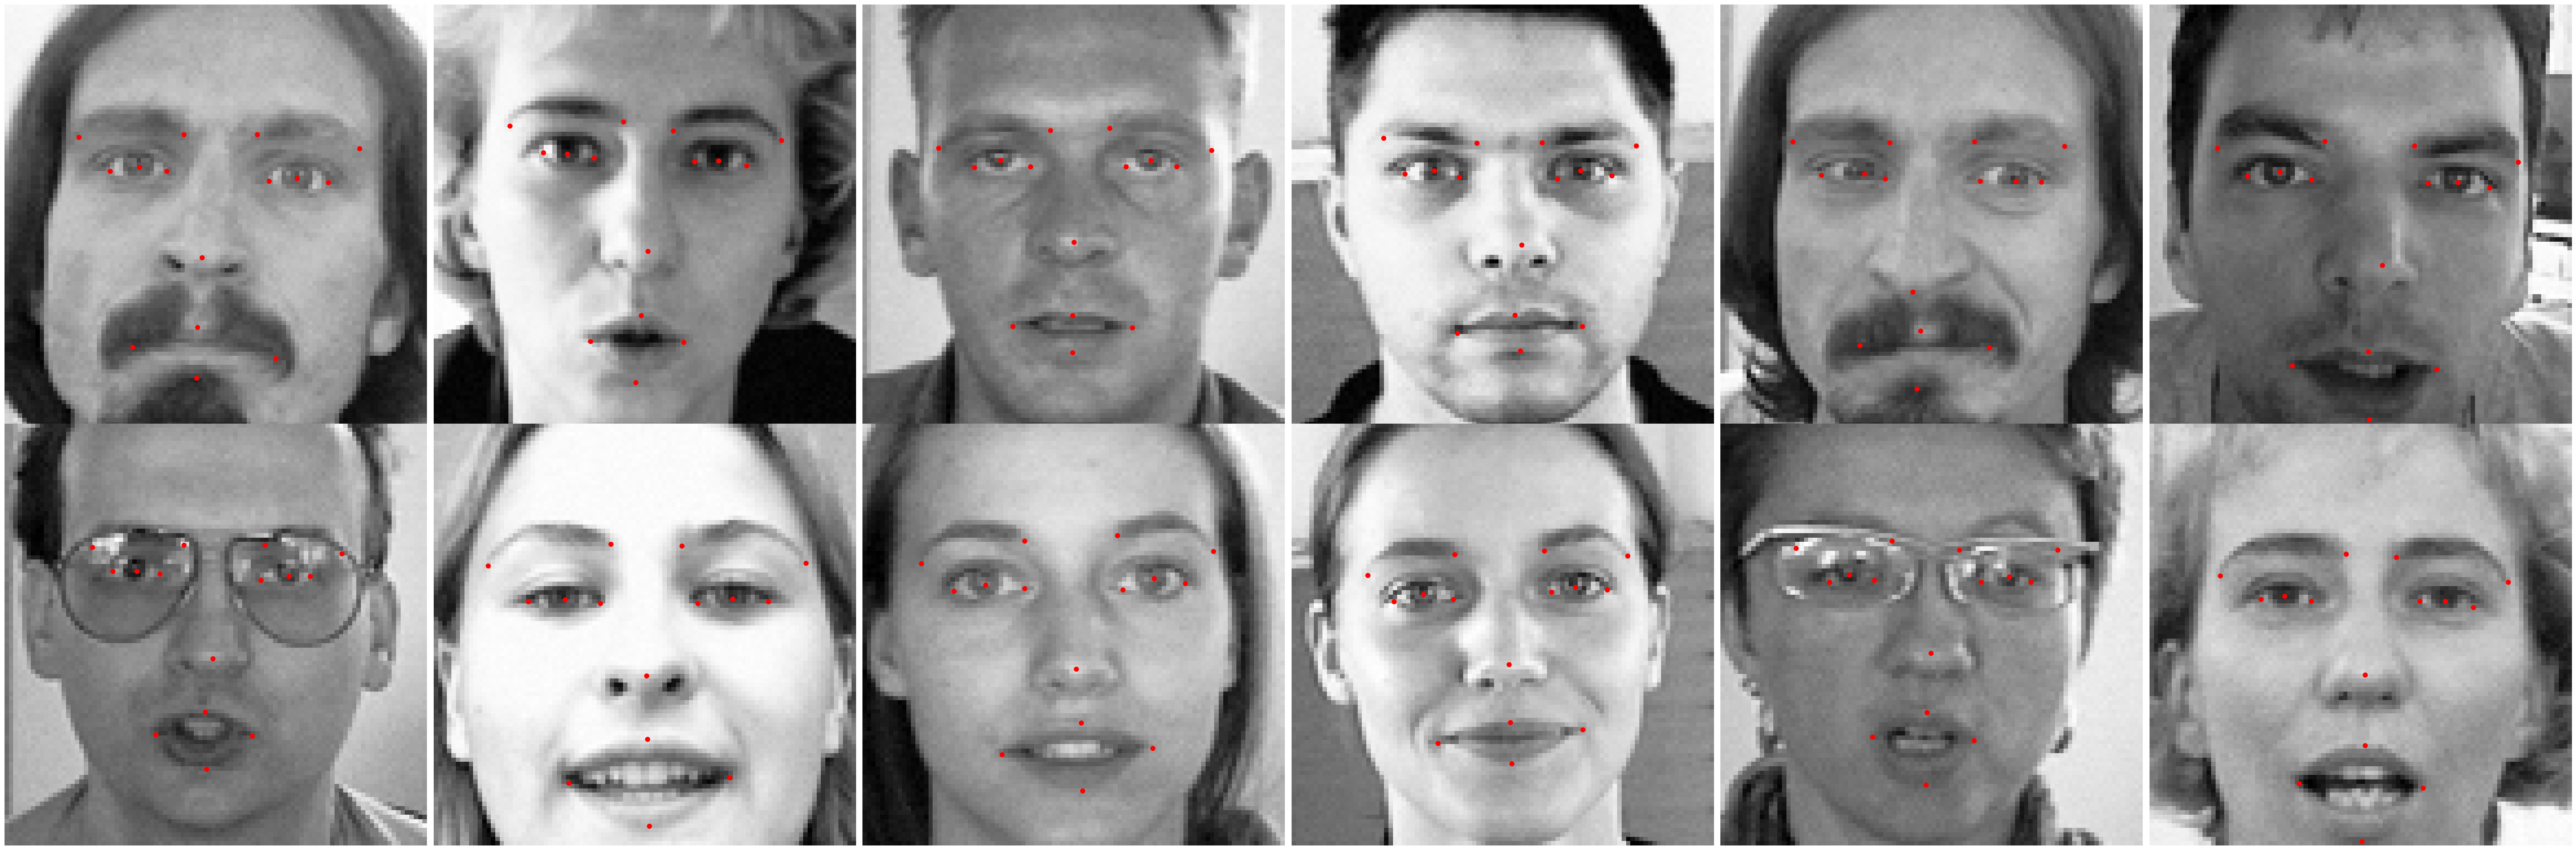

In [48]:
X_noise, y_noise = aug_noise(X_aug,y_aug)
print(X_noise.shape)
plot_images(X_noise[:12], y_noise[:12], 6, shrinkage=0.1)

#finalize training data

In [49]:
# First check all shapes
print(X_noise.shape, y_noise.shape)
print(X_brt.shape, y_brt.shape)
print(X_shift.shape, y_shift.shape)
print(X_rot.shape, y_rot.shape)

(2140, 96, 96, 1) (2140, 30)
(4280, 96, 96, 1) (4280, 30)
(3946, 96, 96, 1) (3946, 30)
(4280, 96, 96, 1) (4280, 30)


In [50]:
X = np.concatenate((X_fill, X_noise, X_brt, X_shift, X_rot))
y = np.concatenate((y_fill, y_noise, y_brt, y_shift, y_rot))

print(X.shape, y.shape)
print(X.min(), "----",X.max())
print(y.min(), "----", y.max())

(21695, 96, 96, 1) (21695, 30)
-0.11743485835545203 ---- 1.2
-1.4202186712259675 ---- 97.92002017642149


Building RESNET50 model

In [51]:
model = tf.keras.models.Sequential()
pretrained_model = ResNet50(input_shape=(96,96,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True

model.add(Conv2D(3, (1,1), padding='same', input_shape=(96,96,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 96, 96, 3)         6         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 30)                61470     
                                                      

In [52]:
# Define callbacks

# Early stopping if no improvement
early_stop = EarlyStopping(monitor = 'loss', 
                           patience = 30, 
                           mode = 'min',
                           baseline=None)

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.7,
                              patience = 5, 
                              min_lr = 1e-15,
                              mode = 'min', 
                              verbose = 1)

# Compile the model

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

In [53]:
history=model.fit(x=X,
                  y=y,
                  epochs=150,
                  batch_size=64,
                  validation_split=0.15,
                  callbacks=[early_stop,reduce_lr])

Epoch 1/150
289/289 [==============================] - 83s 160ms/step - loss: 92.8818 - acc: 0.6044 - val_loss: 107.8437 - val_acc: 0.5677 - lr: 0.0010
Epoch 2/150
289/289 [==============================] - 43s 150ms/step - loss: 5.4685 - acc: 0.7791 - val_loss: 51.2892 - val_acc: 0.5680 - lr: 0.0010
Epoch 3/150
289/289 [==============================] - 43s 150ms/step - loss: 3.9060 - acc: 0.8146 - val_loss: 26.9689 - val_acc: 0.6608 - lr: 0.0010
Epoch 4/150
289/289 [==============================] - 43s 148ms/step - loss: 2.9347 - acc: 0.8341 - val_loss: 26.6521 - val_acc: 0.7441 - lr: 0.0010
Epoch 5/150
289/289 [==============================] - 43s 151ms/step - loss: 2.5523 - acc: 0.8450 - val_loss: 32.5836 - val_acc: 0.6676 - lr: 0.0010
Epoch 6/150
289/289 [==============================] - 44s 151ms/step - loss: 2.4870 - acc: 0.8495 - val_loss: 19.8342 - val_acc: 0.7680 - lr: 0.0010
Epoch 7/150
289/289 [==============================] - 43s 149ms/step - loss: 2.1535 - acc: 0.8572

In [53]:
# Save the model

model.save("FKD_KB1V1_E_Result-Model-ResNet50.h5")

with open('FKD_KB1V1_E_Result-History-ResNet50.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Plot Acc and Loss

In [54]:
def plot_acc_loss(history):
    """
    Function to plot acc and loss of the training results:
    INPUT:
        history: object of the model fitting results
    OUT:
        A plot of training and validation acc per epoch
        A plot of training and validation loss per opoch
    """
    # Plot loss and acc 

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Plot training and validation acc per epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.legend()
    plt.figure()
    print("")

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

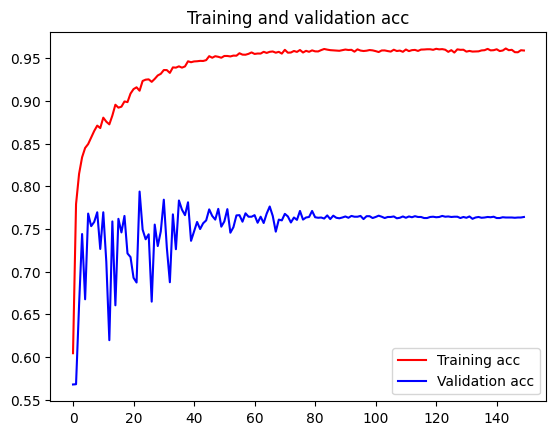

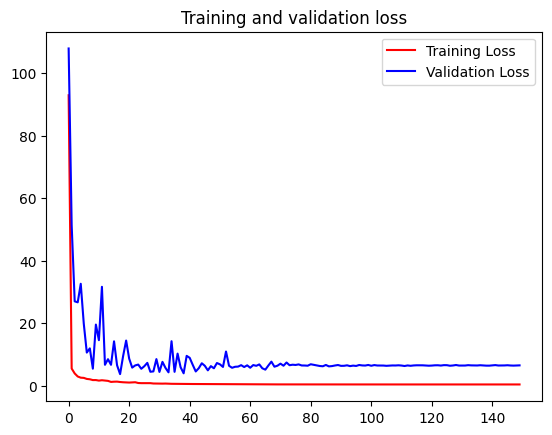

In [55]:
plot_acc_loss(history)

Predict on test data

In [56]:
timag = []
for i in range(0,1783):
    timg = test_data['Image'][i].split(' ')
    timag.append(timg)

timage_list = np.array(timag,dtype = 'float')
X_test = timage_list.reshape(-1,96,96,1) 
X_test = X_test/255.0
print(X_test.shape)

(1783, 96, 96, 1)


In [57]:
y_test = model.predict(X_test)
print(y_test.min(), y_test.max())

56/56 [==============================] - 3s 28ms/step
3.9118352 92.91228


Number of rows: 2, number of cols: 6
Figure width: 57, height: 19


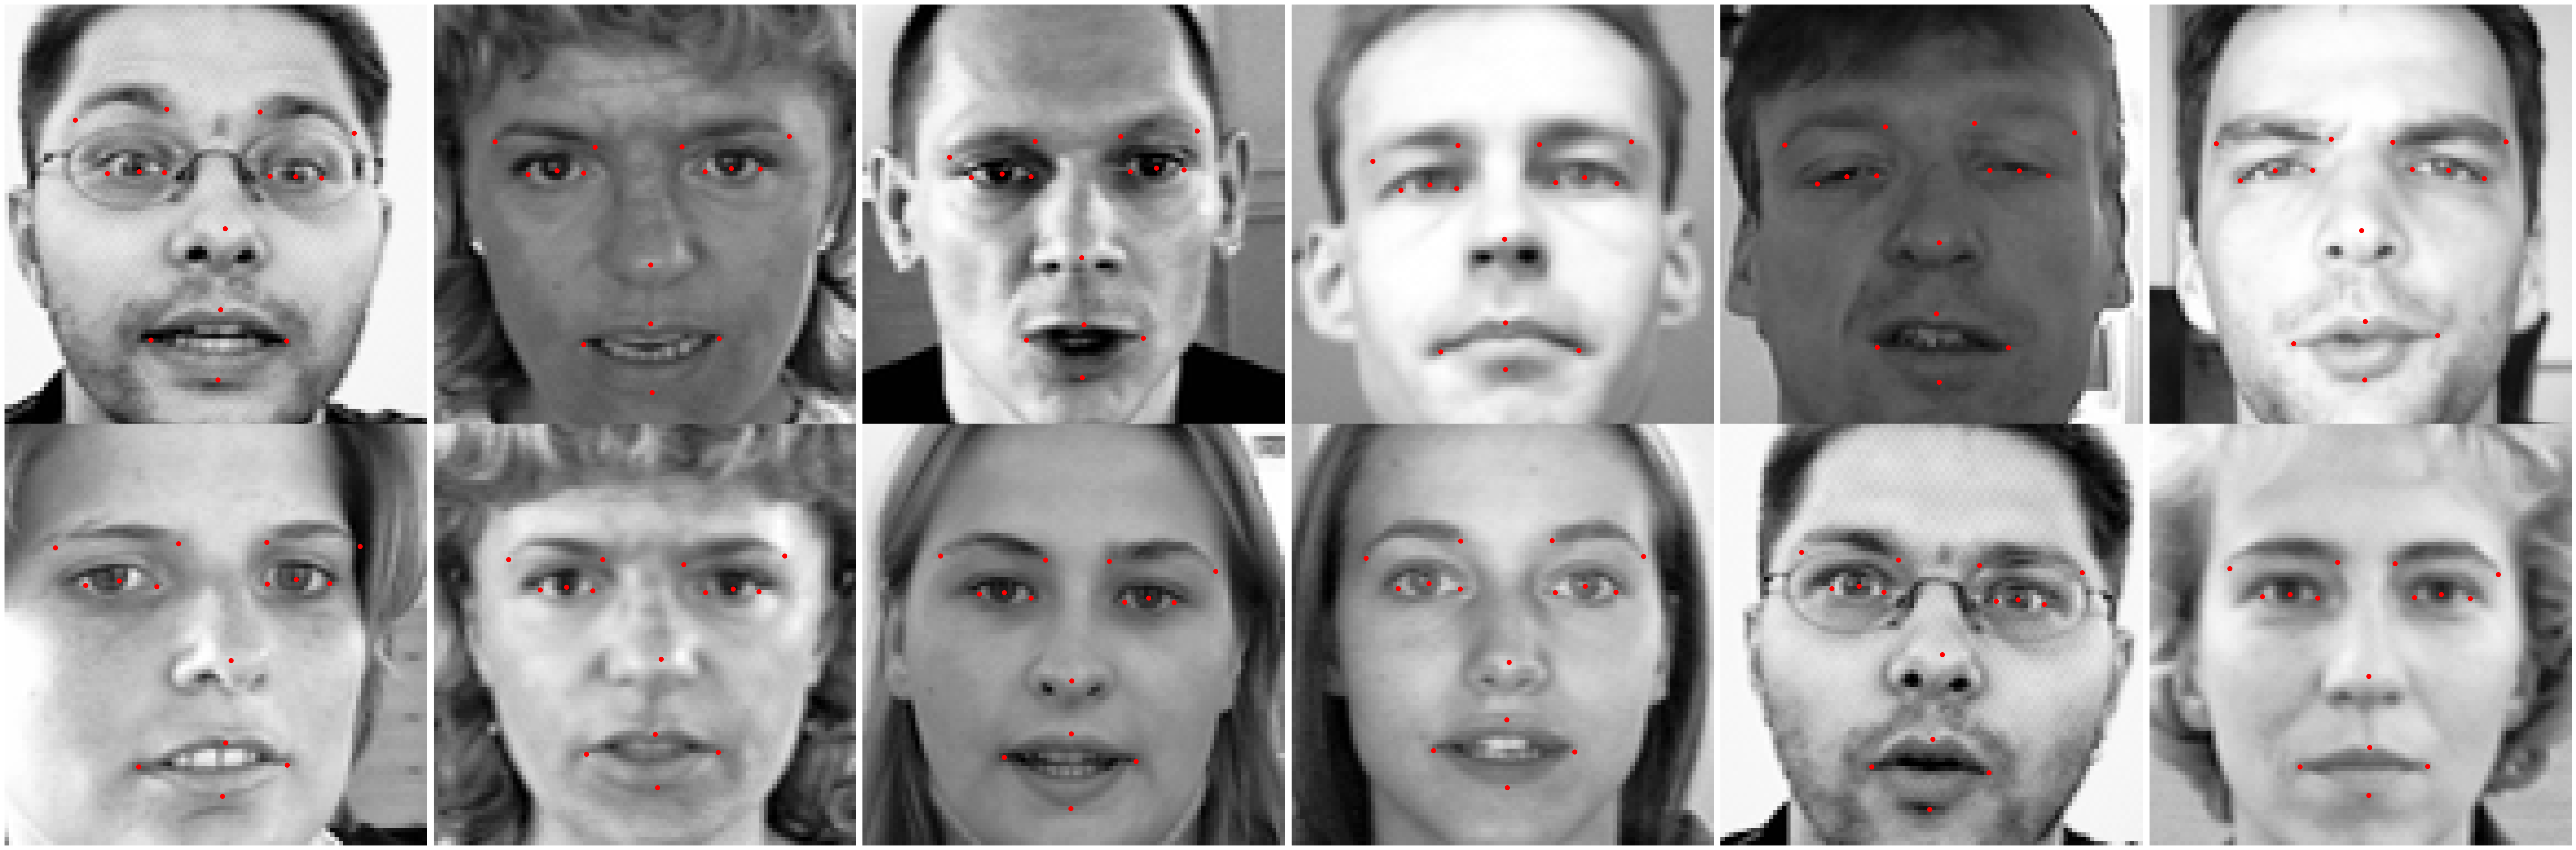

In [58]:
# Plot sample test images
plot_images(X_test[:12], y_test[:12], 6, shrinkage=0.1)